# looking into old calibration file for dalec

need to load in the data that I've calibrated with the old file and see how this compares with the new calibration data!

idea is to make sure the new calibration file isn't the issue I'm getting with the diff betweem 2022 and 2023

In [1]:
import os
import sys
lib_path = os.path.abspath(os.path.join(os.path.abspath(''), 'functions/'))
sys.path.append(lib_path)
# need to append our functions dir to the path! 
import dalecLoad as dl

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import spectralConv
import seaborn as sns

import datetime

from scipy.signal import savgol_filter

In [2]:
# more work needed!!!!
# think only the dateOnly thing doesn't work, so fine for my work atm

def reloadDeltaCorr(filepath, keepFlags=0, onlyRrs=True, dropFlag=False, keepDelta=False, dateOnly=False):
    '''
    loads csv file generated by Dalin's R code into pandas df
    keepFlags selects which DeltaCor_flag should be accepted
        eg. keepFlags=[0, 1] will keep good data AND data with Oxygen aborption flag
        flags:
            0: good data
            1: Oxygen aborption at 760nm is too strong, may influence the Rrs shape
            2: out of the training range of the method
            3: extremely turbid, algae bloom, floating materials, high TSM waters
            4: negative results between 400-700 nm after delta correction
    onlyRrs drops all other columns except the output Rrs columns
    '''
    df = pd.read_csv(filepath)
    
    if type(keepFlags) is not list:
        keepFlags = [keepFlags]
    
    df = df[df['DeltaCor_flag'].isin(keepFlags)]
    
    if onlyRrs:
        if keepDelta:
            df.drop(['Unnamed: 0', 'Rrs400', 'DeltaCor_method', 'RHW'], 
                   axis=1, inplace=True)
        else:
            df.drop(['Unnamed: 0', 'Rrs400', 'DeltaCor_method', 'RHW', 'Delta'], 
                   axis=1, inplace=True)
    if dropFlag:
        df.drop(['DeltaCor_flag'], 
               axis=1, inplace=True)
        
    df.rename(columns={'Rrs400.1': 'Rrs400'}, inplace=True)
    #df['id'] = df.index
    df_long = pd.wide_to_long(df, 'Rrs', i='Date', j='Wavelength')
    
    df_long.sort_index(inplace=True)
    

    
    # currently dateOnly doesn't do what I want! need to rename the index! 

    df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)),
                                               df_long.index.get_level_values(level=1)])
    
    if dateOnly:
        # resample to daily 
        df_long = df_long.groupby([pd.Grouper(freq='1d', level=0)] + ['Wavelength']).median()
        df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)).date,
                                                   df_long.index.get_level_values(level=1)])
        df_long.index.names = ['Date', 'Wavelength']
    
    return df_long

In [3]:
spect_w = dl.load_DALEC_spect_wavelengths('data/calibrated_full/2022/LOG_0071.dtf')

savWindowLen = 21 # 21 nm is recommeneded by Jiang et al., 2020, ISPRS.
                  # https://doi.org/10.1016/j.isprsjprs.2020.05.003
savPolyOrder = 4
# Dalin doesn't specify in the paper what filter order, but I think he uses R and 4 appears to be the deafult  


outputFileName = 'TEST_TEST.csv'

DALEC_files = []
for file in os.listdir('data/calibrated_full/2022_good_files/'):
    if file.endswith(".dtf") and file not in ['LOG_0098.dtf',
                                              'LOG_0099.dtf'
                                              'LOG_0100.dtf'
                                              'LOG_0107.dtf']:
        DALEC_files.append(file)

for i, filen in enumerate(DALEC_files):
    # load log
    log = dl.load_DALEC_dir('data/calibrated_full/2022_good_files/', 
                            file_names=[filen])
    print('loaded. Now resampling, regridding etc... \n')
    # resample to 5 min intervals
    log_re = dl.resampleMultiLog(log, freq='5min')
    # regrid and calc Rrs
    df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
    # reformat
    df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
    df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
    df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
    df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
    # apply savgol filter
    dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                     axis=1, result_type='broadcast')
    
    Rcode_path = os.path.abspath(os.path.join(os.path.abspath(''), 'R-code/'))

    outputPath = os.path.join(Rcode_path, 'data/' + outputFileName)
    if i == 0:
        dfSmooth.to_csv(outputPath, mode='w')
    else:
        dfSmooth.to_csv(outputPath, mode='a', header=False) # use append mode to add all data to one csv

loading ... data/calibrated_full/2022_good_files/LOG_0081.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0080.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0082.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0097.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0083.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0087.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0079.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0086.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0090.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0084.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0085.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0088.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0077.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0076.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0089.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0100.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0074.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0075.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0071.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0099.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0107.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 



In [4]:
log

Roll Solar Elev     Temp Pitch  \
Channel spectral_ind Datetime                                                  
Ed      21           2022-09-12 09:00:10.854  -1.0       25.6  25.8125   1.0   
Lsky    217          2022-09-12 09:00:10.854  -1.0       25.6    24.75   1.0   
        218          2022-09-12 09:00:10.854  -1.0       25.6    24.75   1.0   
        219          2022-09-12 09:00:10.854  -1.0       25.6    24.75   1.0   
        220          2022-09-12 09:00:10.854  -1.0       25.6    24.75   1.0   
...                                            ...        ...      ...   ...   
        21           2022-09-12 13:00:02.654   3.0       37.0     35.5  -2.0   
        22           2022-09-12 13:00:02.654   3.0       37.0     35.5  -2.0   
        23           2022-09-12 13:00:02.654   3.0       37.0     35.5  -2.0   
        25           2022-09-12 13:00:02.654   3.0       37.0     35.5  -2.0   
Lu      220          2022-09-12 13:00:02.654   3.0       37.0   31.625  -2.0   

                                                      Lon   Relaz Solar Azi  \
Channel spectral_ind Datetime                                                 
Ed      21           2022-09-12 09:00:10.854  -3.92305679  -123.6     124.8   
Lsky    217          2022-09-12 09:00:10.854  -3.92305679  -123.6     124.8   
        218          2022-09-12 09:00:10.854  -3.92305679  -123.6     124.8   
        219          2022-09-12 09:00:10.854  -3.92305679  -123.6     124.8   
        220          2022-09-12 09:00:10.854  -3.92305679  -123.6     124.8   
...                                                   ...     ...       ...   
        21           2022-09-12 13:00:02.654  -3.92305679  -135.9     195.1   
        22           2022-09-12 13:00:02.654  -3.92305679  -135.9     195.1   
        23           2022-09-12 13:00:02.654  -3.92305679  -135.9     195.1   
        25           2022-09-12 13:00:02.654  -3.92305679  -135.9     195.1   
Lu      220          2022-09-12 13:00:02.654  -3.92305679  -135.9     195.1   

                                             Voltage         Lat  \
Channel spectral_ind Datetime                                      
Ed      21           2022-09-12 09:00:10.854    11.4  56.1468505   
Lsky    217          2022-09-12 09:00:10.854    11.4  56.1468505   
        218          2022-09-12 09:00:10.854    11.4  56.1468505   
        219          2022-09-12 09:00:10.854    11.4  56.1468505   
        220          2022-09-12 09:00:10.854    11.4  56.1468505   
...                                              ...         ...   
        21           2022-09-12 13:00:02.654    11.4  56.1468505   
        22           2022-09-12 13:00:02.654    11.4  56.1468505   
        23           2022-09-12 13:00:02.654    11.4  56.1468505   
        25           2022-09-12 13:00:02.654    11.4  56.1468505   
Lu      220          2022-09-12 13:00:02.654    11.4  56.1468505   

                                             Integration Time  \
Channel spectral_ind Datetime                                   
Ed      21           2022-09-12 09:00:10.854               48   
Lsky    217          2022-09-12 09:00:10.854               45   
        218          2022-09-12 09:00:10.854               45   
        219          2022-09-12 09:00:10.854               45   
        220          2022-09-12 09:00:10.854               45   
...                                                       ...   
        21           2022-09-12 13:00:02.654                9   
        22           2022-09-12 13:00:02.654                9   
        23           2022-09-12 13:00:02.654                9   
        25           2022-09-12 13:00:02.654                9   
Lu      220          2022-09-12 13:00:02.654                1   

                                              Saturation Flag Heading Gearpos  \
Channel spectral_ind Datetime                                                   
Ed      21           2022-09-12 09:00:10.854                0     1.2  -118.7   
Lsk

<Axes: xlabel='Wavelength', ylabel='Rrs_median'>

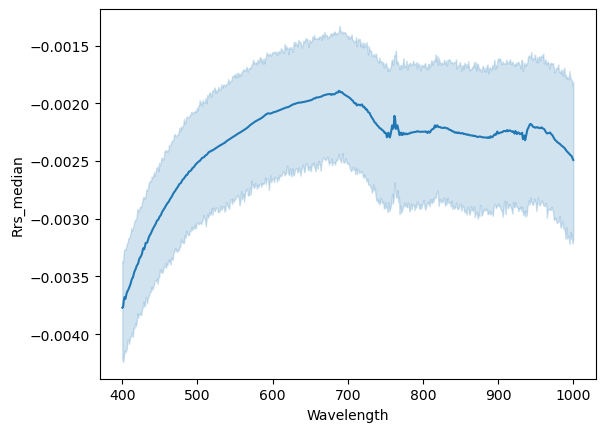

In [6]:
sns.lineplot(data=df_gridded, x='Wavelength', y='Rrs_median')

In [9]:
# load delta corrected spectra
dalecDelta = pd.read_csv('R-code/data/TEST_TEST.csv',
                             )

In [13]:
dalecDelta.melt(id_vars='Date', value_vars=None, var_name=None, value_name='value')

,Date,variable,value
0,2022-08-07 10:00:00,Rrs400,0.002527
1,2022-08-07 10:05:00,Rrs400,0.002382
2,2022-08-07 10:10:00,Rrs400,0.002382
3,2022-08-07 10:15:00,Rrs400,0.002627
4,2022-08-07 10:20:00,Rrs400,0.002484
...,...,...,...
530678,2022-09-12 12:40:00,Rrs1000,-0.004173
530679,2022-09-12 12:45:00,Rrs1000,-0.008216
530680,2022-09-12 12:50:00,Rrs1000,-0.007274
530681,2022-09-12 12:55:00,Rrs1000,-0.007767


In [12]:
dalecDelta

,Date,Rrs400,Rrs401,Rrs402,Rrs403,Rrs404,Rrs405,Rrs406,Rrs407,Rrs408,...,Rrs991,Rrs992,Rrs993,Rrs994,Rrs995,Rrs996,Rrs997,Rrs998,Rrs999,Rrs1000
0,2022-08-07 10:00:00,0.002527,0.002526,0.002528,0.002533,0.002540,0.002547,0.002555,0.002563,0.002570,...,0.001575,0.001586,0.001595,0.001602,0.001605,0.001606,0.001603,0.001597,0.001588,0.001576
1,2022-08-07 10:05:00,0.002382,0.002380,0.002381,0.002385,0.002390,0.002395,0.002401,0.002407,0.002412,...,0.001264,0.001272,0.001277,0.001280,0.001282,0.001284,0.001285,0.001289,0.001296,0.001308
2,2022-08-07 10:10:00,0.002382,0.002377,0.002377,0.002379,0.002384,0.002390,0.002397,0.002403,0.002408,...,0.001238,0.001242,0.001245,0.001249,0.001254,0.001260,0.001268,0.001279,0.001292,0.001309
3,2022-08-07 10:15:00,0.002627,0.002627,0.002630,0.002636,0.002643,0.002652,0.002661,0.002669,0.002677,...,0.001919,0.001924,0.001928,0.001929,0.001928,0.001927,0.001924,0.001923,0.001923,0.001926
4,2022-08-07 10:20:00,0.002484,0.002479,0.002479,0.002481,0.002485,0.002490,0.002496,0.002501,0.002506,...,0.001455,0.001459,0.001460,0.001460,0.001459,0.001458,0.001458,0.001462,0.001470,0.001485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,2022-09-12 12:40:00,-0.004274,-0.004250,-0.004231,-0.004217,-0.004206,-0.004198,-0.004191,-0.004184,-0.004177,...,-0.004057,-0.004069,-0.004080,-0.004091,-0.004101,-0.004113,-0.004125,-0.004139,-0.004154,-0.004173
879,2022-09-12 12:45:00,-0.007938,-0.007902,-0.007879,-0.007865,-0.007857,-0.007853,-0.007853,-0.007853,-0.007852,...,-0.007939,-0.007958,-0.007981,-0.008006,-0.008035,-0.008067,-0.008101,-0.008138,-0.008176,-0.008216
880,2022-09-12 12:50:00,-0.006576,-0.006544,-0.006523,-0.006510,-0.006502,-0.006499,-0.006499,-0.006499,-0.006500,...,-0.007135,-0.007158,-0.007180,-0.007200,-0.007218,-0.007234,-0.007248,-0.007259,-0.007268,-0.007274
881,2022-09-12 12:55:00,-0.007439,-0.007407,-0.007384,-0.007370,-0.007360,-0.007354,-0.007350,-0.007346,-0.007342,...,-0.007543,-0.007567,-0.007592,-0.007618,-0.007644,-0.007671,-0.007697,-0.007722,-0.007746,-0.007767


In [14]:
df_gridded

Rrs_median
Date                Wavelength            
2022-09-12 09:00:00 400.0        -0.003328
                    401.0        -0.003317
                    402.0        -0.003257
                    403.0        -0.003228
                    404.0        -0.003234
...                                    ...
2022-09-12 13:00:00 996.0        -0.005059
                    997.0        -0.005110
                    998.0        -0.005162
                    999.0        -0.005149
                    1000.0       -0.005136

[29449 rows x 1 columns]

In [15]:
log = dl.load_DALEC_dir('data/calibrated_full/2022_good_files/', 
                       #     file_names=[filen]
                       )
print('loaded. Now resampling, regridding etc... \n')
# resample to 5 min intervals
log_re = dl.resampleMultiLog(log, freq='5min')
# regrid and calc Rrs
df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
# reformat
df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
# apply savgol filter
dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                 axis=1, result_type='broadcast')

loading ... data/calibrated_full/2022_good_files/LOG_0081.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0080.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0082.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0097.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0083.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0087.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0079.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0086.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0090.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0084.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0085.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0088.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0077.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0076.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0089.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0100.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0074.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0075.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0071.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0099.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0098.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2022_good_files/LOG_0107.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 



In [21]:
df_gridded = df_gridded.reset_index()
df_gridded['date'] = df_gridded.Date.dt.date

## 2022 data

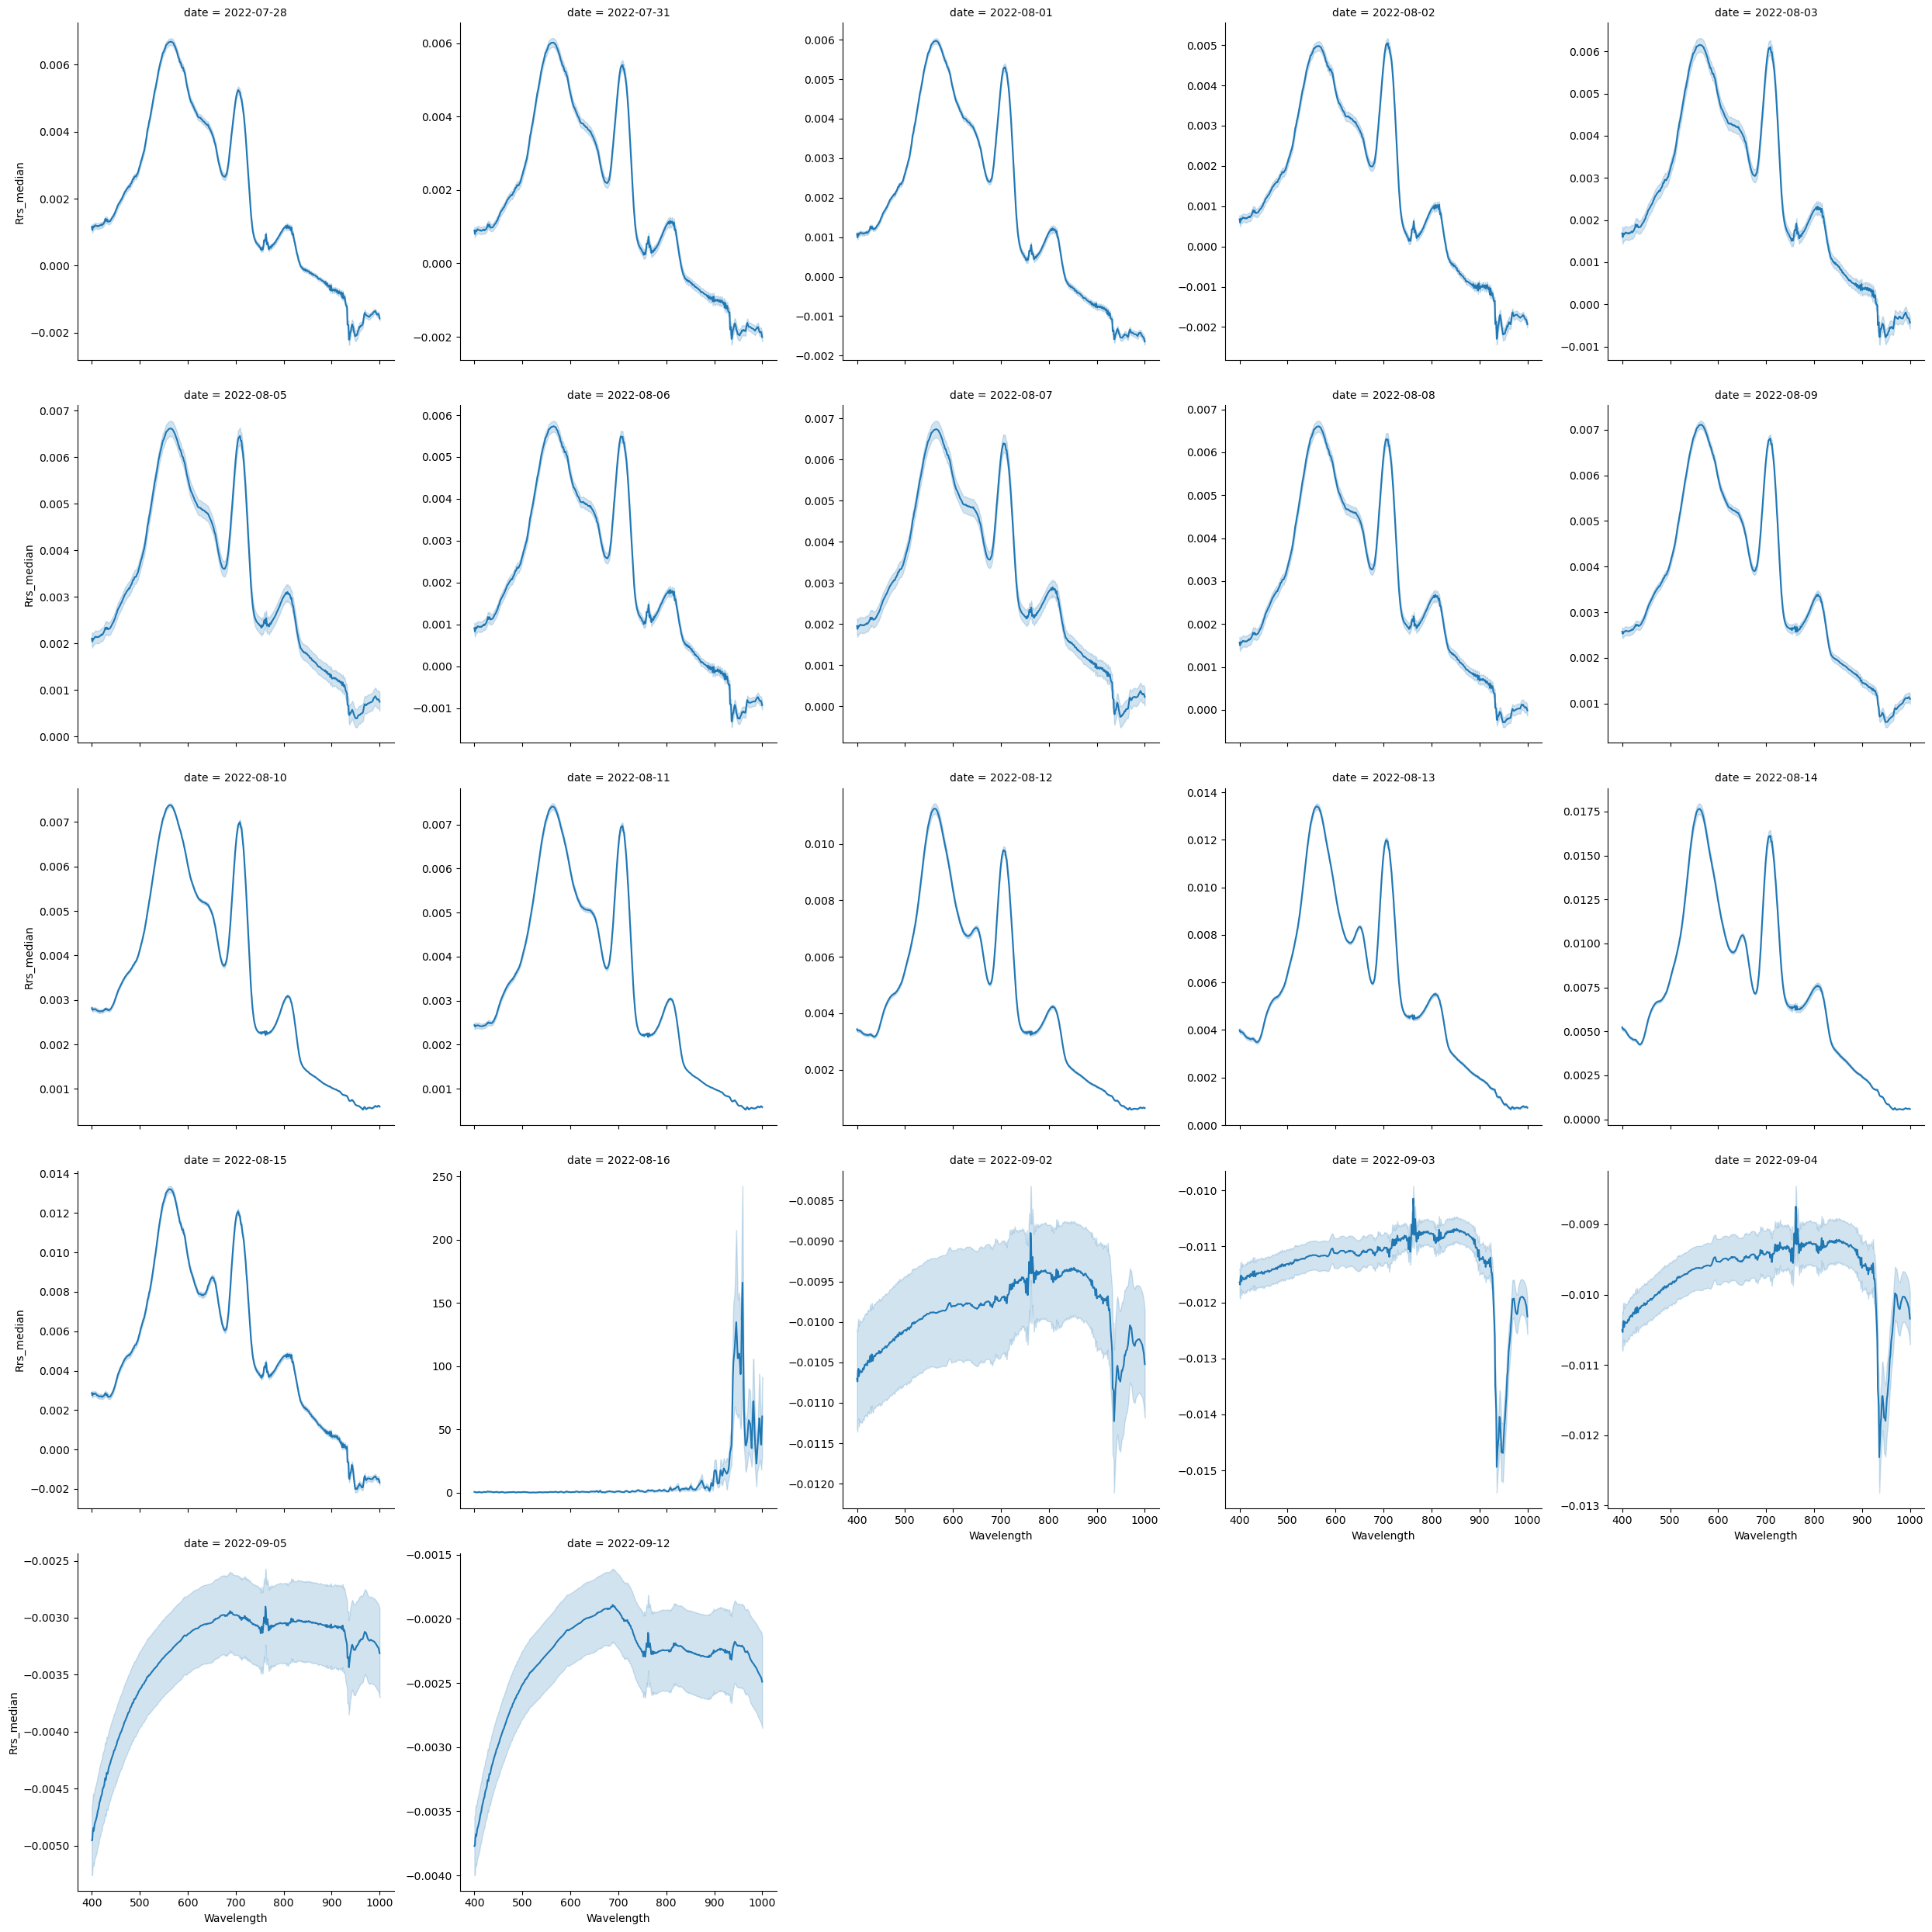

In [24]:
sns.relplot(data=df_gridded, x='Wavelength', y='Rrs_median', col='date',
            kind='line', col_wrap=5, errorbar='se', facet_kws={'sharey': False})

In [26]:
log = dl.load_DALEC_dir('data/calibrated_full/2023_good_files/', 
                            file_names=['LOG_0008.dtf',
                                        'LOG_0017.dtf',
                                        'LOG_0027.dtf',
                                        'LOG_0037.dtf',
                                        'LOG_0047.dtf',
                                        'LOG_0053.dtf',
                                        'LOG_0067.dtf',
                                        'LOG_0087.dtf',
                                        'LOG_0097.dtf',
                                       ]
                       )
print('loaded. Now resampling, regridding etc... \n')
# resample to 5 min intervals
log_re = dl.resampleMultiLog(log, freq='5min')
# regrid and calc Rrs
df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
# reformat
df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
# apply savgol filter
dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                 axis=1, result_type='broadcast')

loading ... data/calibrated_full/2023_good_files/LOG_0008.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0017.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0027.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0037.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0047.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0053.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0067.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0087.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/2023_good_files/LOG_0097.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 



In [27]:
df_gridded = df_gridded.reset_index()
df_gridded['date'] = df_gridded.Date.dt.date

## 2023 data, with latest calib file

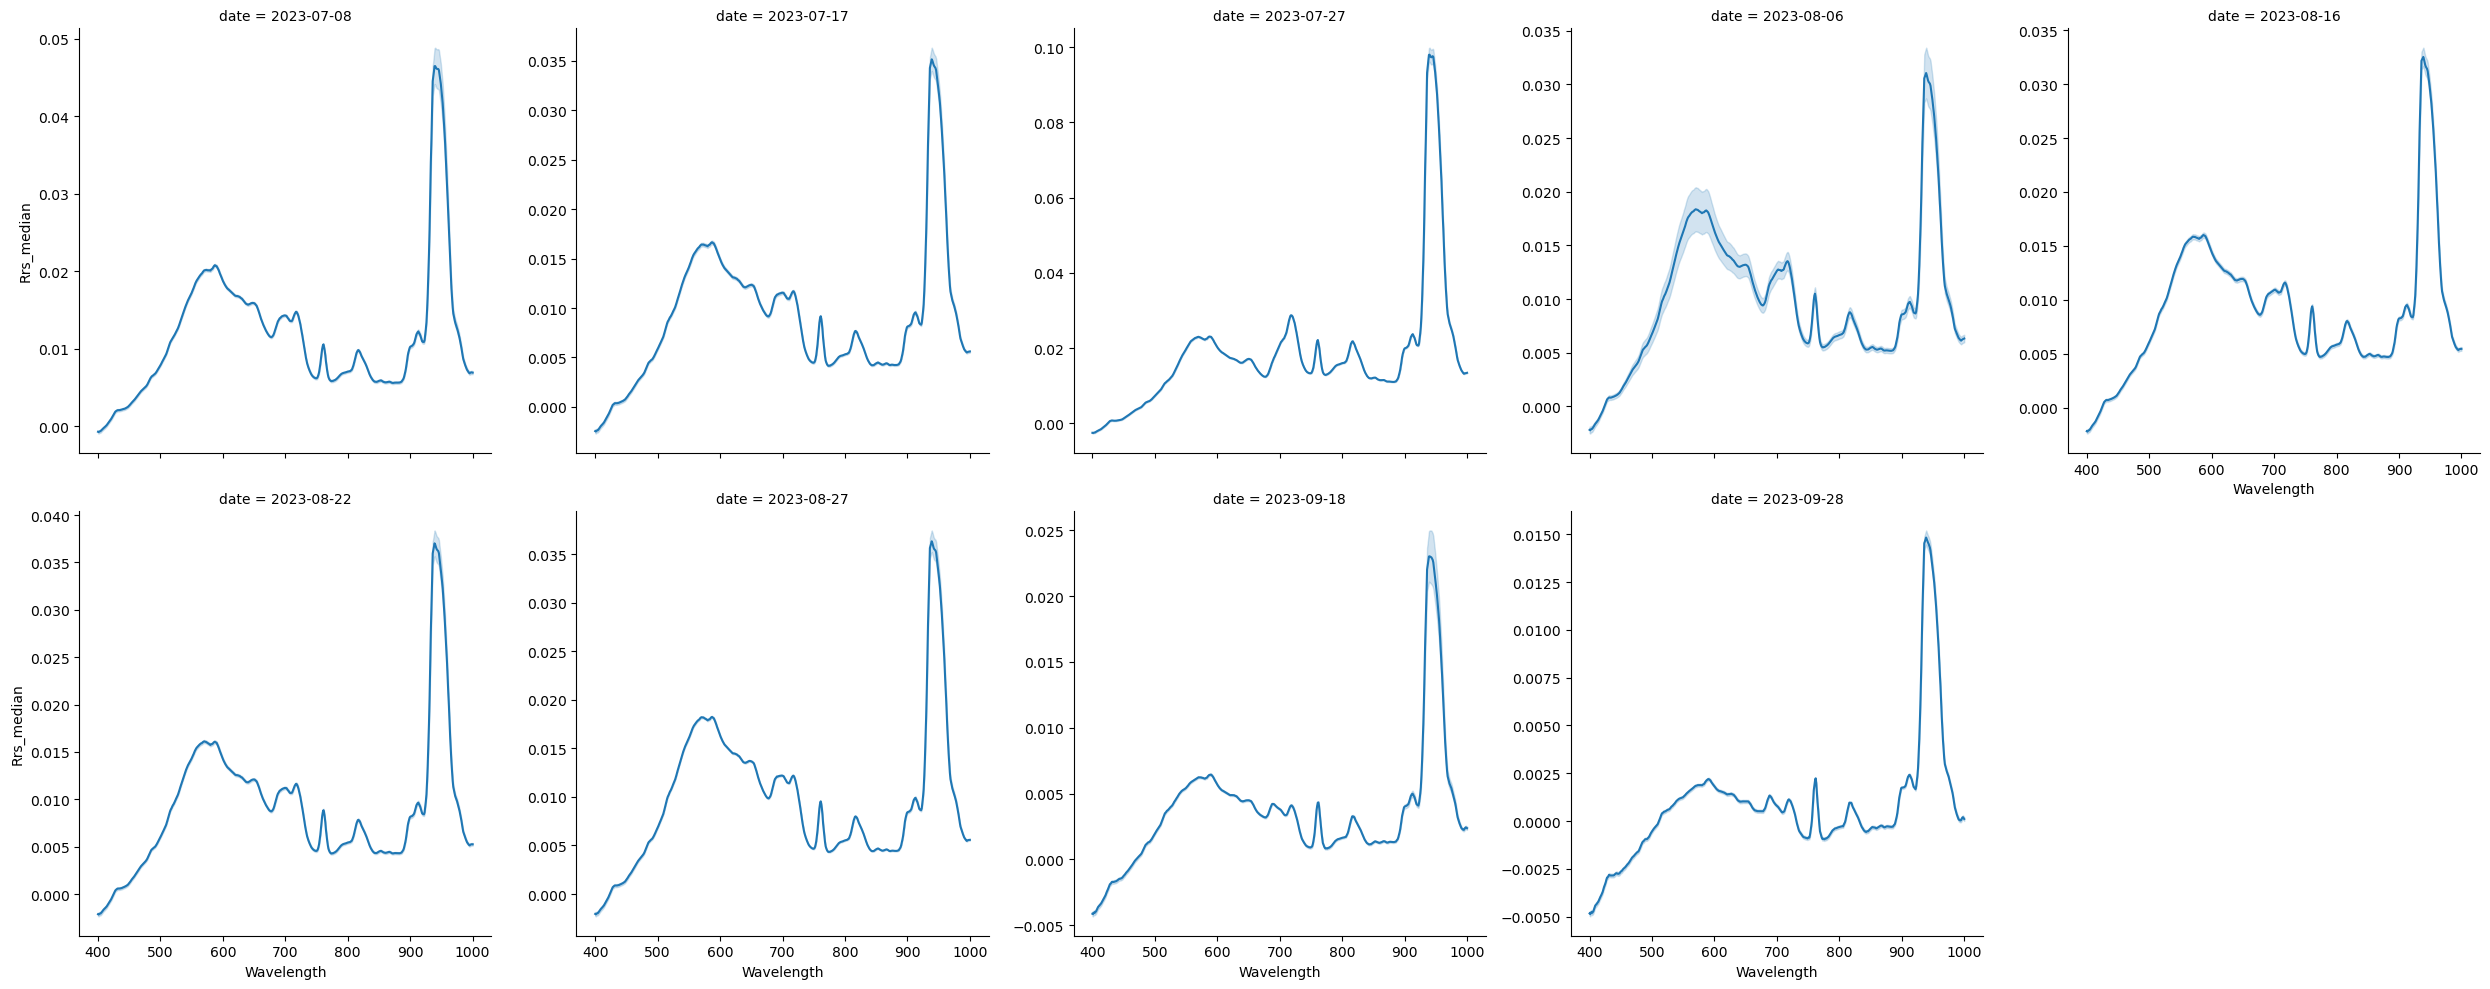

In [28]:
sns.relplot(data=df_gridded, x='Wavelength', y='Rrs_median', col='date',
            kind='line', col_wrap=5, errorbar='se', facet_kws={'sharey': False})

In [29]:
log = dl.load_DALEC_dir('data/calibrated_full/calibrated_old_cal_file_good/', 
                            file_names=['LOG_0008.dtf',
                                        'LOG_0017.dtf',
                                        'LOG_0027.dtf',
                                        'LOG_0037.dtf',
                                        'LOG_0047.dtf',
                                        'LOG_0053.dtf',
                                        'LOG_0067.dtf',
                                        'LOG_0087.dtf',
                                        'LOG_0097.dtf',
                                       ]
                       )
print('loaded. Now resampling, regridding etc... \n')
# resample to 5 min intervals
log_re = dl.resampleMultiLog(log, freq='5min')
# regrid and calc Rrs
df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
# reformat
df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
# apply savgol filter
dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                 axis=1, result_type='broadcast')

loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0008.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0017.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0027.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0037.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0047.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0053.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0067.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0087.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loading ... data/calibrated_full/calibrated_old_cal_file_good/LOG_0097.dtf


/Users/daa5@stir.ac.uk/Project/DALEC_processing/functions/dalecLoad.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DALEC_log = pd.read_csv(filepath,


loaded. Now resampling, regridding etc... 



In [30]:
df_gridded = df_gridded.reset_index()
df_gridded['date'] = df_gridded.Date.dt.date

## 2023 data, with OLD calib file

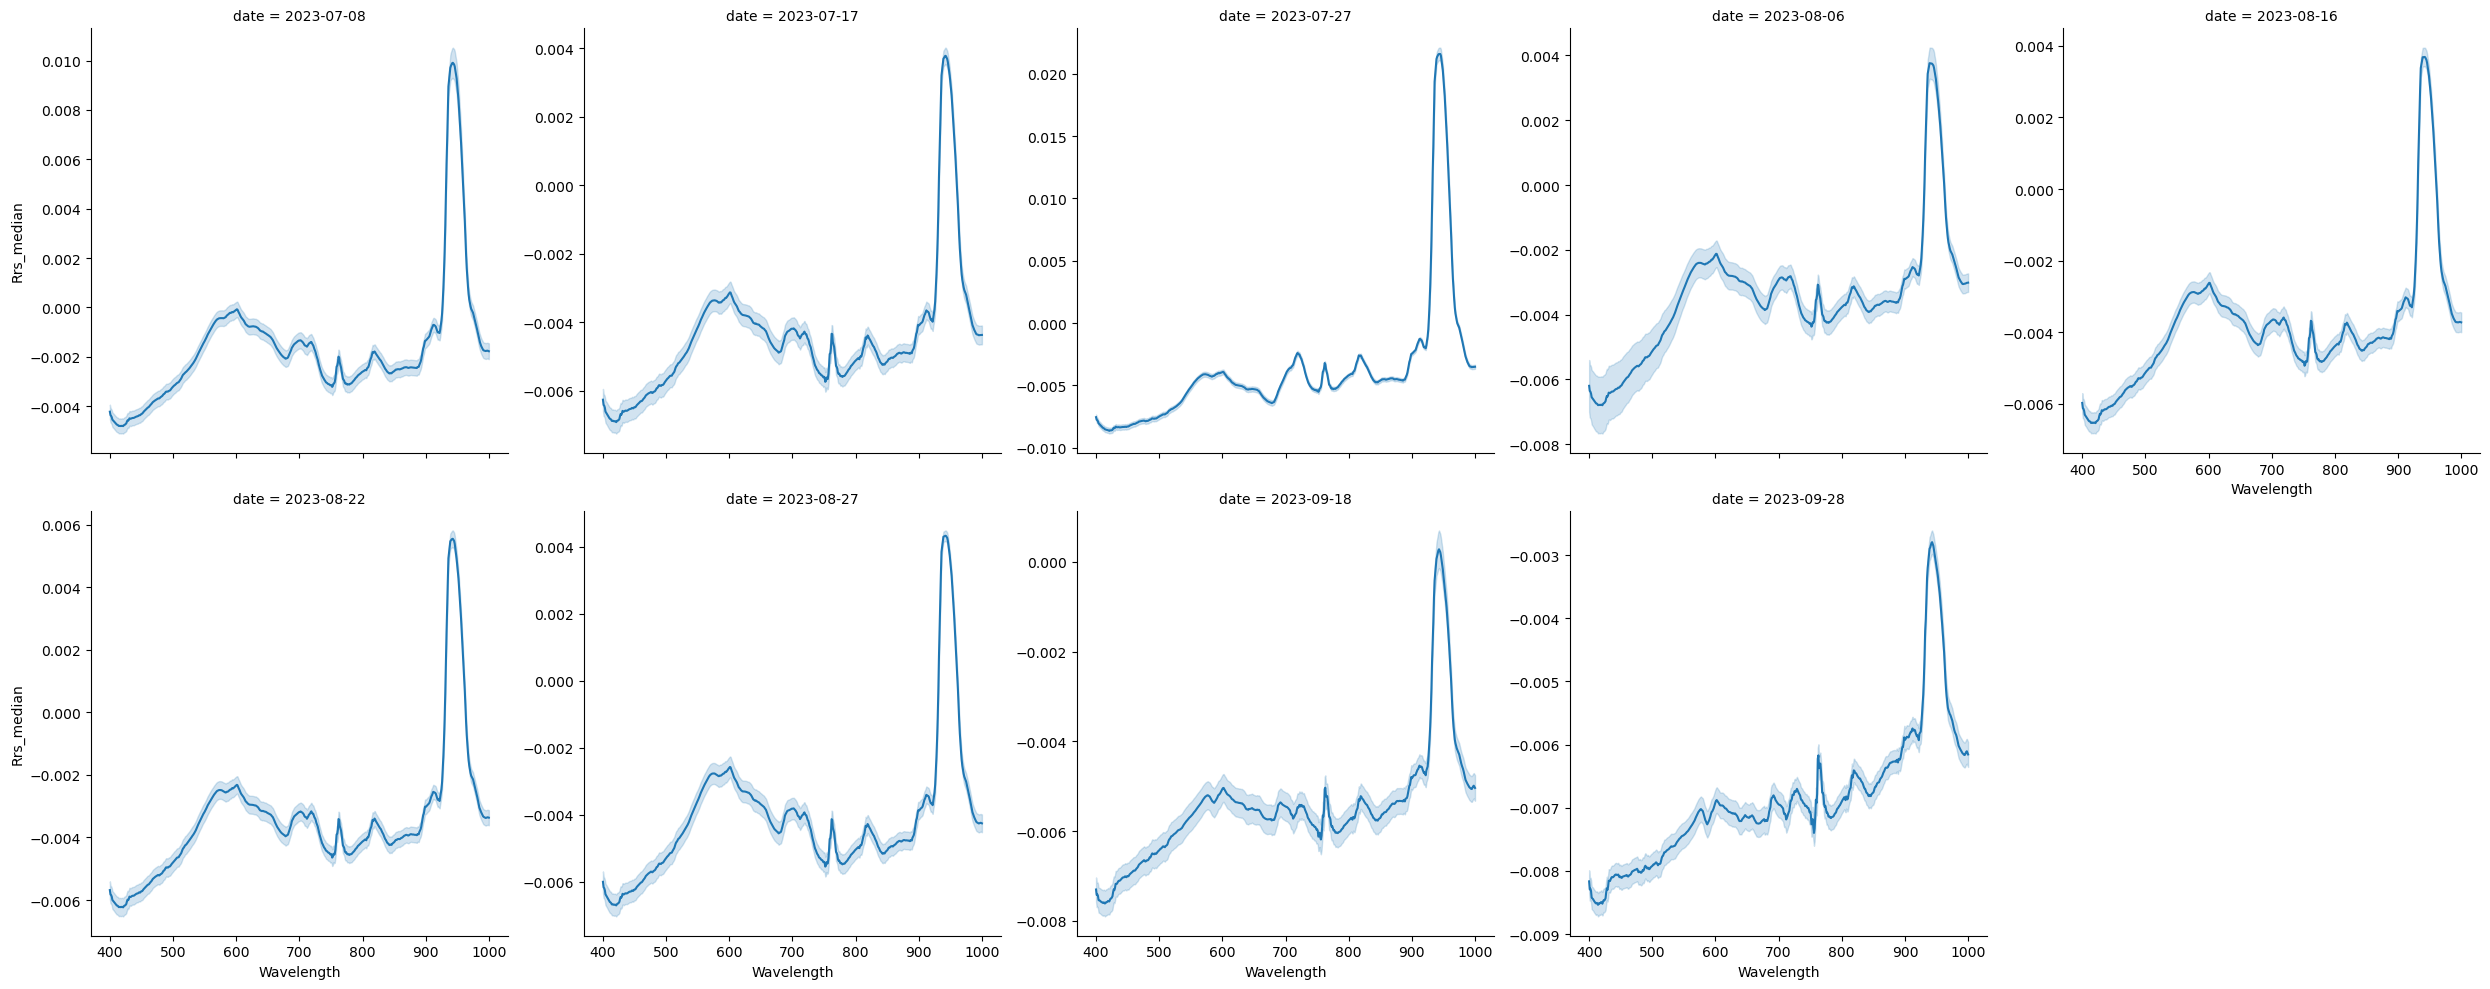

In [31]:
sns.relplot(data=df_gridded, x='Wavelength', y='Rrs_median', col='date',
            kind='line', col_wrap=5, errorbar='se', facet_kws={'sharey': False})

# Conclusion

- issue definitely isn't to do with the new calibration file
- the 2023 data calibrated with the old file still looks weird, and keeps the same features as the 2023 data with the 'correct' calibration file

So, either the issues with the spectra are due to a sensor fault, or what we're seeing is true, and influenced either by bottom effect or macrophytes etc.